# Introduction to earthquake signal processing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GPGN-268/GPGN268-CORE/blob/main/assignments/earthquakes/eq_processing.ipynb)

The this notebook provides a gentle introduction to processing seismic signals of earthquakes. We will use the excellent open-source libraries [ObsPy](https://github.com/obspy/obspy), [SeisBench](https://github.com/seisbench/seisbench), and [PyOcto](https://github.com/yetinam/pyocto) for this exercise.

After completing the assignment you will know how to:

1. Pre-process earthquake time series data using filtering and instrument response removal
2. Plot seismograms, their spectra, and create spectrograms
3. Automatically make P/S picks, associated the picks into events, and roughly locate the earthquakes

Additional resources you may find helpful include:

- [The ObsPy tutorial](https://docs.obspy.org/tutorial/)
- [SeisBench example notebooks](https://github.com/seisbench/seisbench?tab=readme-ov-file#getting-started)
- [PyOcto](https://github.com/yetinam/pyocto)
- [OOP in python](https://realpython.com/python3-object-oriented-programming/)

**->Within this notebook, you need to complete two types of tasks<-**

- Code cells that start with "## Exercise" provide instructions for you to complete in code.
- Text cells which have -> followed by a bold prompt are questions for you to answer.

Before getting started, we need to install the required dependencies.

In [170]:
#@title Install packages


# First ensure ObsPy and Seisbench are installed. We need to restart kernel if not.
try:
    import obspy
    import seisbench
    import numpy as np
except ImportError:
    !pip install obspy
    !pip install seisbench
    !pip install cartopy
    !pip install pyocto
    # resetart kernel
    import IPython
    IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get a client for downloading data
from obspy.clients.fdsn.client import Client

client = Client()

# Part 1: A brief introduction to ObsPy

Like many python libraries, ObsPy implements an object-oriented interface. This means it implements data structures (known as classes) which are used to create *instances*, or *objects*, which manage data and provide methods for operating on the data. If you aren't familiar with this terminology, don't worry, we will go through several examples. The [Real Python OOP Guide](https://realpython.com/python3-object-oriented-programming/) is also a great resource.

For this assignment, you will use a few ObsPy classes. The main ones are [`UTCDateTime`](https://docs.obspy.org/tutorial/code_snippets/utc_date_time.html), [`Stream`](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html), and [`Trace`](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.html).

In [171]:
#@title Part 1 helper functions
# Helper functions for this section. Just run this cell and move on.

def get_fourier_spectrum(trace):
    """
    Return the Fourier Spectrum from the trace and corresponding frequencies.

    Parameters
    ----------
    trace
        The obspy trace to transform to Fourier domain.

    Notes
    -----
        Since the trace data is assumed to be real, the fft is symmetric
        so only the right half (possitive frequencies) are needed.
    """
    fft = np.fft.rfft(trace.data)
    # Get the temporal spacing of data.
    sample_spacing = 1 / trace.stats.sampling_rate
    freqs = np.fft.rfftfreq(len(trace.data), sample_spacing)
    return fft, freqs



## Time

For historical reasons, ObsPy uses `UTCDateTime` objects to represent [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) times. A precise and unified time system is important for studying earthquakes. `UTCDateTime` objects can be created from several formats, including:

1. An [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) string, e.g., "2020-01-03T12:13:23"
2. A number representing seconds from [epoch time](https://en.wikipedia.org/wiki/Unix_time) (Jan 1st 1970).


In [172]:
# Create time from an ISO 8601 string.
time_from_str = obspy.UTCDateTime("2017-09-17T12:01:02.012344")
# Create time from one billion seconds after 1970.
time_from_number = obspy.UTCDateTime(1_000_000_000)
# Get the time right now (according to your computer's clock).
time_now = obspy.UTCDateTime()

You can also create new `UTCDateTime` objects by adding or subtracting any number of seconds.

Subtracting `UTCDateTime` objects gives the difference in seconds.

In [173]:
# 1_000.01 seconds in the future.
future_time = time_now + 1_000.01

# Get the time 100 days in the past (24 hours in a day, 3600 seconds in an hour).
past_time = time_now - 100 * 24 * 3600

# Get the number of seconds between Guy Fawkes day and Pi Day in 1999.
total_seconds = obspy.UTCDateTime("1999-11-05") - obspy.UTCDateTime("1999-03-14")

In [174]:
## Excercise
# Create a UTCDateTime object of your birthday.

bday = obspy.UTCDateTime("2003-10-09")

In [175]:
## Excercise
# Calculate and print how many hours from now to your next birthday.
diff = obspy.UTCDateTime("2024-10-09") - time_now
hours = diff / 3600

print(hours)

4534.163283564167


## Streams and Traces

The `Trace` contains waveform data (a 1D numpy array representing instrument output) and metadata (station name, sampling rate, etc.). It also has several *methods*, which operate on the data/metadata.

The `Stream` is just a container for traces. This graphic is helpful:

![](https://docs.obspy.org/pr/filter/_images/Stream_Trace.png)


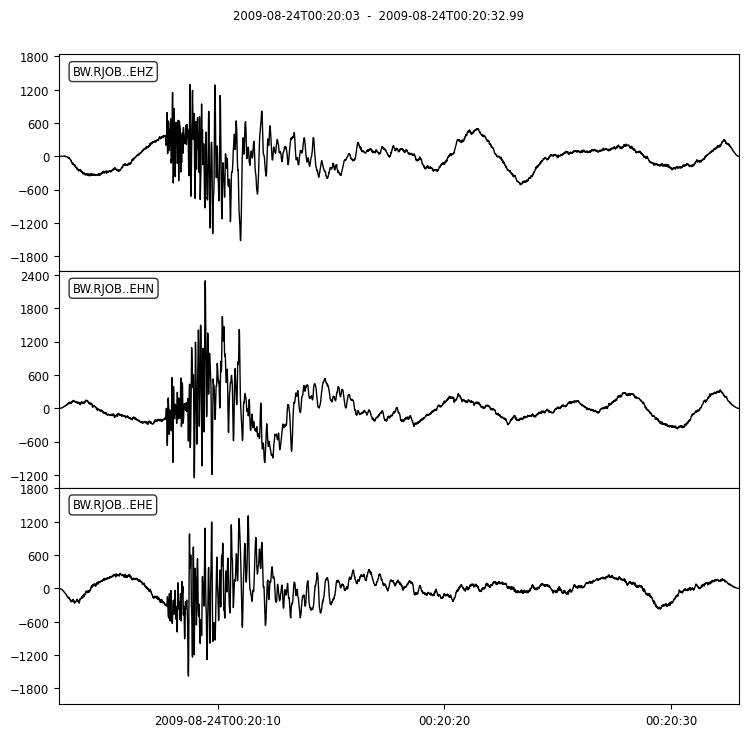

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples

In [176]:
# Create a Stream.
stream = obspy.read()  # You can also pass a path to a data file.
# Plot all of the traces in the stream.
stream.plot();
stream

ObsPy `Stream` instances behave like lists.

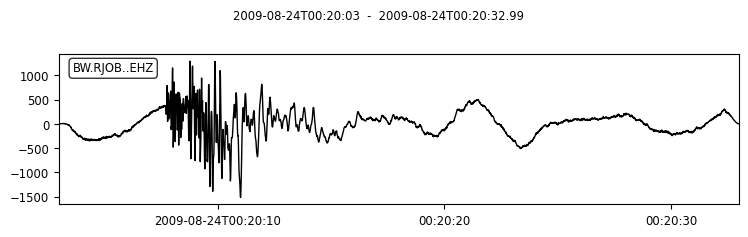

In [177]:
# Get the first trace in a list.
trace = stream[0]
trace.plot();

In [178]:
# Print the metadata about the trace.
print(trace.stats)

         network: BW
         station: RJOB
        location: 
         channel: EHZ
       starttime: 2009-08-24T00:20:03.000000Z
         endtime: 2009-08-24T00:20:32.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3000
           calib: 1.0
    back_azimuth: 100.0
     inclination: 30.0
        response: Channel Response
	From M/S (Velocity in Meters Per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 2.5168e+09 defined at 0.020 Hz
	4 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1500
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.67785e+06
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1


In [179]:
# Print the station name.
station_name = trace.stats.station
print(station_name)

RJOB


In [180]:
# Get the time series data as a numpy array.
data = trace.data
print(data)

[0.         0.00694644 0.07597424 ... 1.93449584 0.98196204 0.44196924]


In [181]:
## Excercise
# Using the starttime and endtime in the stats, calcuate the duration of the
# trace in seconds. Then print it.

start = trace.stats.starttime
end = trace.stats.endtime

print(end - start)

29.99


In [182]:
## Excercise
# Without hardcoding any values, print how many traces are in the stream.
# Hint: remember streams behave like lists.

print(np.size(data))

3000


### Trimming
Traces and streams can be trimmed using the `slice` method. This returns a new trace object.

There is also a `trim` method, but this modifies the trace/stream in place, so `slice` is safer and should be preferred.

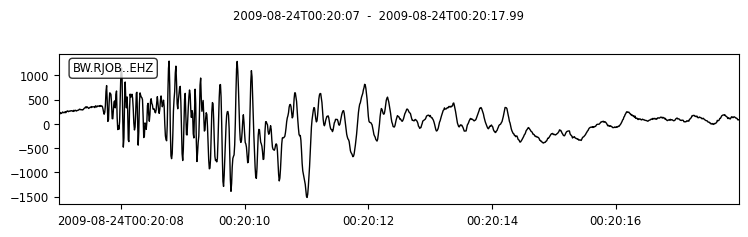

In [183]:
# Trim 4 second from the start and 15 seconds from the end of the trace.
new_starttime = trace.stats.starttime + 4
new_endtime = trace.stats.endtime - 15
trimmed = trace.slice(starttime=new_starttime, endtime=new_endtime)
trimmed.plot();

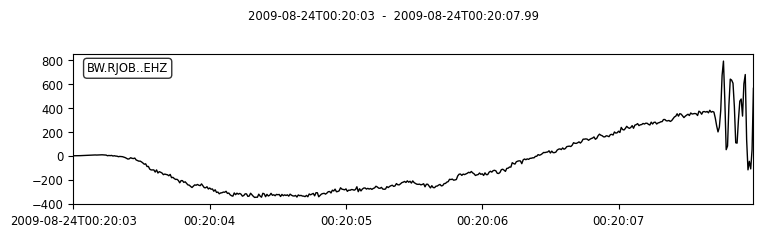

In [184]:
## Excercise
# Create and plot a trace which zooms into the first 5 seconds of the event.

endtime2 = trace.stats.endtime - 25
trimmed2 = trace.slice(starttime=start, endtime=endtime2)
trimmed2.plot();

### Detrending

Detrending is used to remove a trend from data. Both `Stream` and `Trace` have a [detrend](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.detrend.html) method. This modifies the data in place so we first make a copy in case we want to use the original data again later.

Plotting trace with trend


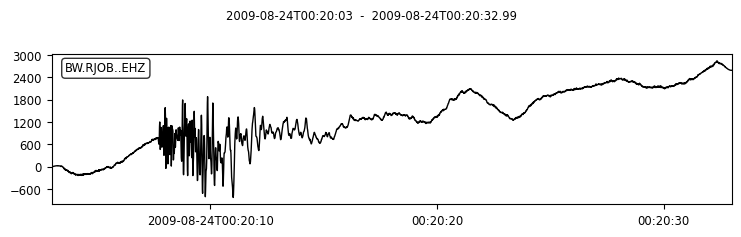

In [185]:
# Create a trace with a linearly increasing trend.
trace_with_trend = trace.copy()
trend = np.linspace(0, trace.data.max()*2, len(trace.data))
trace_with_trend.data += trend

print("Plotting trace with trend")
trace_with_trend.plot();

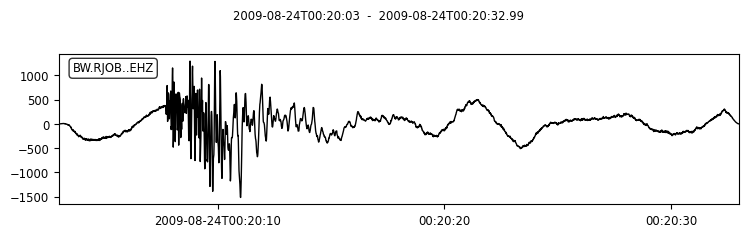

In [186]:
# Remove the trend.
detrended_trace = trace_with_trend.copy().detrend()
detrended_trace.plot();

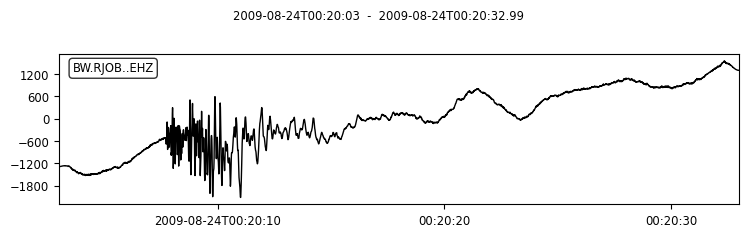

In [187]:
## Excercise
# Use a "constant" type of detrend on the trace_with_trend and plot.
# Hint: Use the link above to see the detrend docs.
import scipy
detrend_2 = trace_with_trend.copy().detrend('constant')
detrend_2.plot();

-> *Why do the two detrended traces look different?*

They look different, because the first detrend defaults to using detrend type "simple." The "simple" type changes the data by subtracting a linear function defined by the first/last sample of the trace. Which increases the amplitude and makes it more linear. While the second detrend uses the type "constant," which subtracts the mean of the data to detrend it. This doesn't change the path, linearity or amplitude, but it changes the bounds. As it moves the p and s wave data primarily into quadrent 4 where the trended data is primarily in quadrent 1.

## Filtering
The [filter method](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html) of both streams and traces is very useful. It allows you to selectively attenuate certain frequencies in the data.

In the example below, notice how the low-frequency background noise is removed.

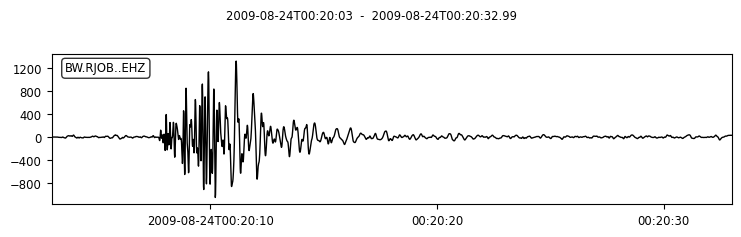

In [188]:
# Attenuate frequencies outside 1 to 10 Hz.
# The .copy() is again used to avoid changing the original trace.
tr_bp_filtered = trace.copy().filter("bandpass", freqmin=1, freqmax=10)
tr_bp_filtered.plot();

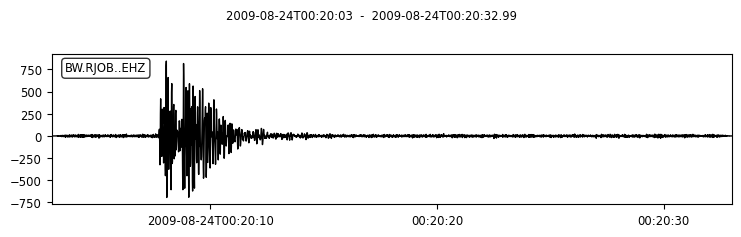

In [189]:
## Excercise
# Apply a 10 Hz highpass filter to the trace and plot it.
# Hint: Don't forget .copy() before filtering and use the link above to see
# the filter docs.

tr_bp_filtered2 = trace.copy().filter("highpass", freq=10)
tr_bp_filtered2.plot();

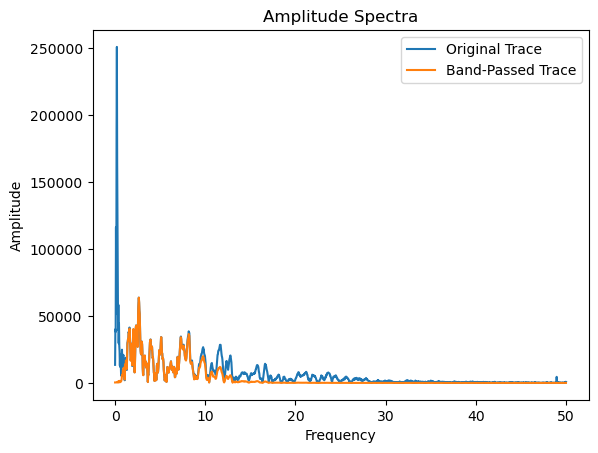

In [190]:
## Excercise
# Plot the amplitude spectra of the original trace and the band-passed trace on
# the same plot. Label each line, the axes, and show the legend.
# Hint: use the helper function `get_fourier_spectrum` defined above.
import numpy as np
#np.abs of the fft,freq

#original trace
org_freq, org_amp = np.abs(get_fourier_spectrum(trace))

#band-passed trace
band_freq, band_amp = np.abs(get_fourier_spectrum(tr_bp_filtered))


plt.plot(org_amp, org_freq, label='Original Trace')
plt.plot(band_amp, band_freq, label='Band-Passed Trace')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Amplitude Spectra')
plt.legend()

**Does this make sense given the filtering we performed?**

Yes it does, it's only in the first quadrent which makes sense as I took the absolute value of the data. The band-passed data looks more filtered, which makes sense as a filter function was used on the data here. The values also show more of a coorleation near their zero values, which makes sense. The spike at the beginning of the original does not make sense. 


## Spectrograms

A [Spectrogram](https://en.wikipedia.org/wiki/Spectrogram) is a type of plot that captures captures temporal variations in frequency. It is created from a series of short (often overlapping) time windows which are transformed to the Fourier domain. See ObsPy's [spectrogram docs](https://docs.obspy.org/packages/autogen/obspy.imaging.spectrogram.spectrogram.html#obspy.imaging.spectrogram.spectrogram) for more details.

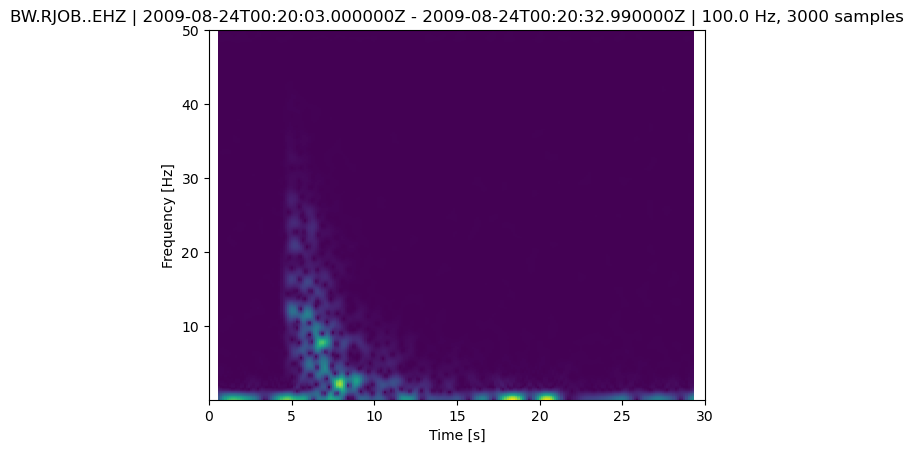

In [191]:
trace.spectrogram()

**-> Looking at the spectrogram, does the frequency increase or decrease as time progresses in seismic signal?**

It decreases, as it has some high in magnitude values from 5 seconds to 10 seconds. Then it essentially flatlines before and after that with frequency values around 0Hz-1Hz.

## Instrument response

The signal recorded by a seismic sensor, $s(t)$ is not the actual ground motion $u(t)$ but the ground motion convolved with an instrument response $r(t)$. This can be represented in the time domain with the convolution operator ($\circledast$):

$$
s(t) = u(t) \circledast r(t)  
$$

or in the frequency domain with spectral multiplication:

$$
S(f) = U(f) R(f)
$$


To get the ground motion from the output of a seismic instrument, which we might want to estimate magnitudes, we need to remove the response. In the simplest form this involves dividing the recorded spectrum by the instrument response spectrum. However, oddities in instrument response file formats and the need to avoid dividing small numbers makes this a bit more complicated. Luckily, ObsPy helps with those details.

Response information can either be attached to a trace or contained in an `Inventory`. In the case of the default trace/stream, the responses are already attached as `stats.response`.

To see how this works, we will download waveforms and station data associated with a [large mine disaster](https://en.wikipedia.org/wiki/Crandall_Canyon_Mine).



In [192]:
# Download waveforms
time = obspy.UTCDateTime("2007-08-06T08:48:40")
cc_trace = client.get_waveforms(
    network='US',
    station='DUG',
    starttime=time + 25,
    endtime=time+120,
    location='*',
    channel='BHZ',
)[0]

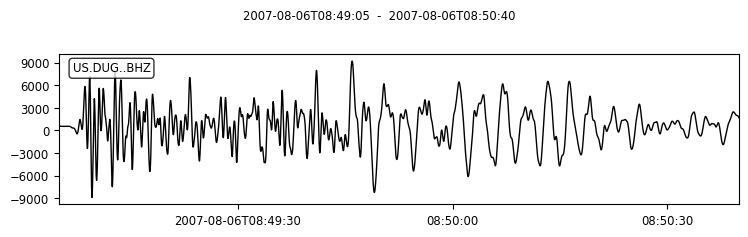

In [193]:
cc_trace.plot();

In [194]:
# Download the station response
inv = client.get_stations(
    starttime=time,
    endtime=time+120,
    network="US",
    station="DUG",
    location="*",
    channel="BHZ",
    level="response",
)

In [195]:
cc_trace_no_response = cc_trace.copy().remove_response(inventory=inv)

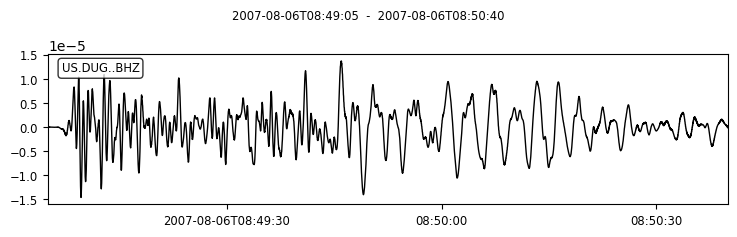

In [196]:
cc_trace_no_response.plot();

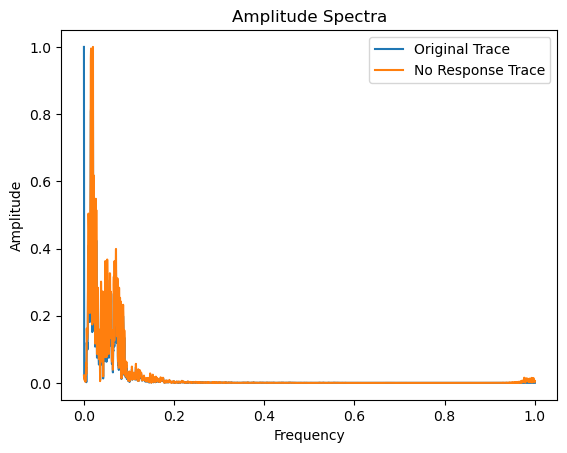

In [197]:
## Exercise
# Get the normalized (by dividing by max value) amplitude spectra of the
# downloaded trace and the one with the response removed.
# Plot both responses.
# hint: again, get_fourier_spectrum will be useful.

#original trace
org_freq, org_amp = np.abs(get_fourier_spectrum(cc_trace))
freq_max1 = np.max(org_freq)
amp_max1= np.max(org_amp)

norm_freq1 = org_freq / freq_max1 #dividing by max value
norm_amp1 = org_amp / amp_max1

#no response trace
resp_freq, resp_amp = np.abs(get_fourier_spectrum(cc_trace_no_response))
freq_max2 = np.max(resp_freq)
amp_max2= np.max(resp_amp)

norm_freq2 = resp_freq / freq_max2 #dividing by max value
norm_amp2 = resp_amp / amp_max2


plt.plot(norm_amp1, norm_freq1, label='Original Trace')
plt.plot(norm_amp2, norm_freq2, label='No Response Trace')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Amplitude Spectra')
plt.legend()

---
# Part 2: A brief introduction to SeisBench

[SeisBench](https://github.com/seisbench/seisbench) is a python library for applying machine learning in Seismology. It provides a common interface to many pre-trained deep learning models to automate earthquake processing tasks.

It really is magic... but sometimes the [dangerous kind](https://en.wikipedia.org/wiki/The_Monkey%27s_Paw) that does unexpected things.

In [198]:
#@title Part 2 helper functions

# Utility code for this section. Simply run this cell and move on.

def to_df(list_thing):
    """
    Convert a list-like thing to a dataframe.

    Also convert columns of obspy UTCDateTime objects to numpy datetime64.

    Parameters
    ----------
    list_thing
        A collection of objects which have `__dict__`.
    """
    out = [x.__dict__ for x in list_thing]
    df = pd.DataFrame(out)
    # Convert all times columns to numpy datetime64.
    for col in df.columns:
        if 'time' in col:
            df[col] = [
                np.datetime64(str(x)[:26] )
                for x in df[col].values
            ]
    # Add "time" column which will be used by the associator. Must be
    # a float
    diffs = df['peak_time'] - df['peak_time'].min()
    df['time'] = diffs / np.timedelta64(1, 's')
    # Need to add station code.
    split = df['trace_id'].str.split(".", expand=True)
    df['network'] = split[0]
    df['station'] = split[1]
    return df


## A New Dataset

First, we download one hour of data starting 10 minutes after the main event. We need all three components (up, east, and north) for the picker.  

In [199]:
import seisbench.models as sbm

In [200]:
# Download waveforms, note: we need all 3 components for this picker.
time_1 = obspy.UTCDateTime("2007-08-06T08:48:40") + 10*60
time_2 = time_1 + 3600
cc_stream = client.get_waveforms(
    network='UU',
    station='SRU',
    starttime=time_1,
    endtime=time_2,
    location='*',
    channel='HH?',
)

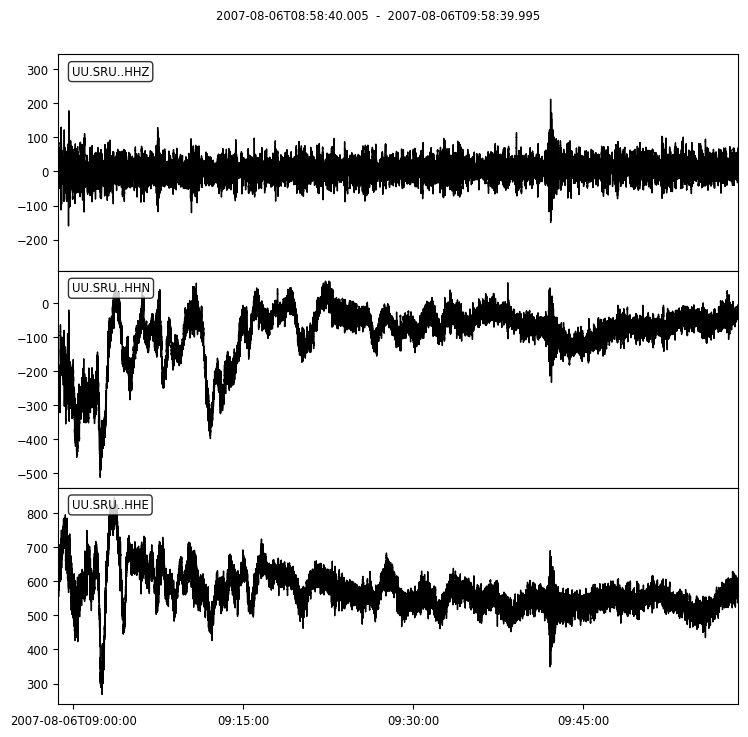

In [201]:
cc_stream.plot();

It is difficult to see more than 1 or 2 aftershocks, but they are there!

Let's try a highpass filter to bring them out.

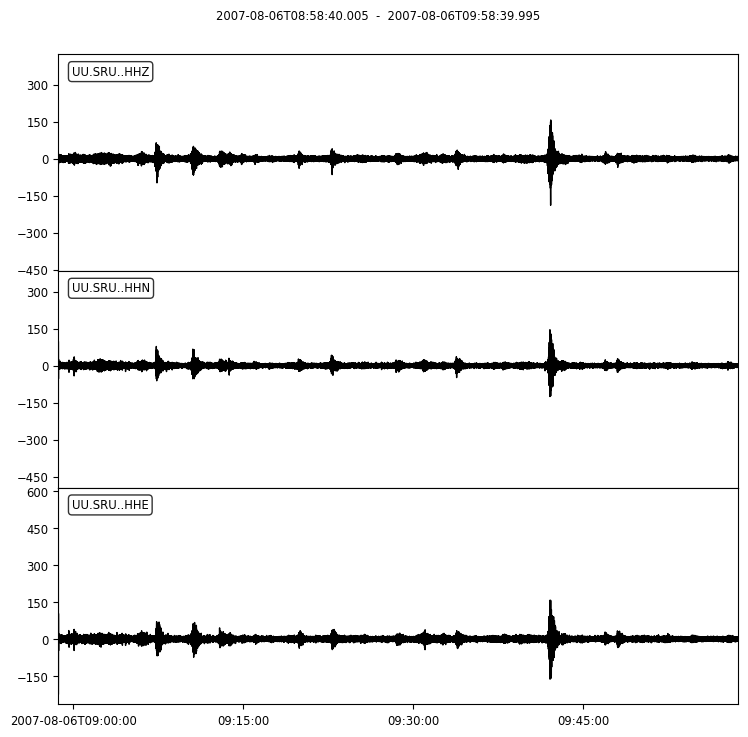

In [202]:
hp_cc_stream = cc_stream.copy().filter("highpass", freq=1)

hp_cc_stream.plot();

## Deep denoiser

Maybe we can do better? Let's try the [Deep Denoiser](https://ieeexplore.ieee.org/abstract/document/8802278) on the highpass data. We do this by creating a seisbench model and loading the trained model weights.

Then we use the `annotate` method to return a new `Stream` object with the model outputs.

In [203]:
# Create a denoiser model from the original training weights.
denoiser = sbm.DeepDenoiser.from_pretrained("original")

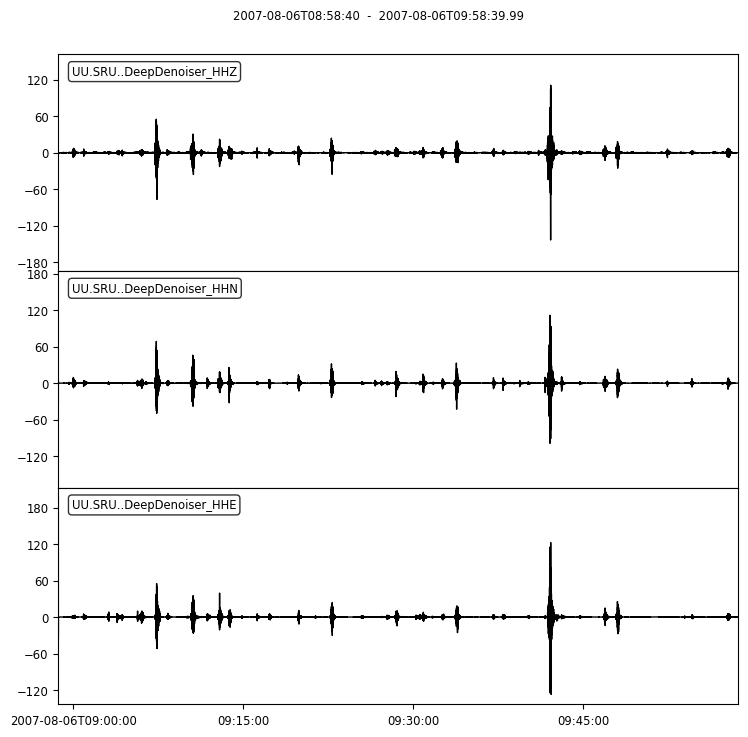

In [204]:
# Denoise the high-passed stream and plot.
denoised_st = denoiser.annotate(hp_cc_stream)
denoised_st.plot();

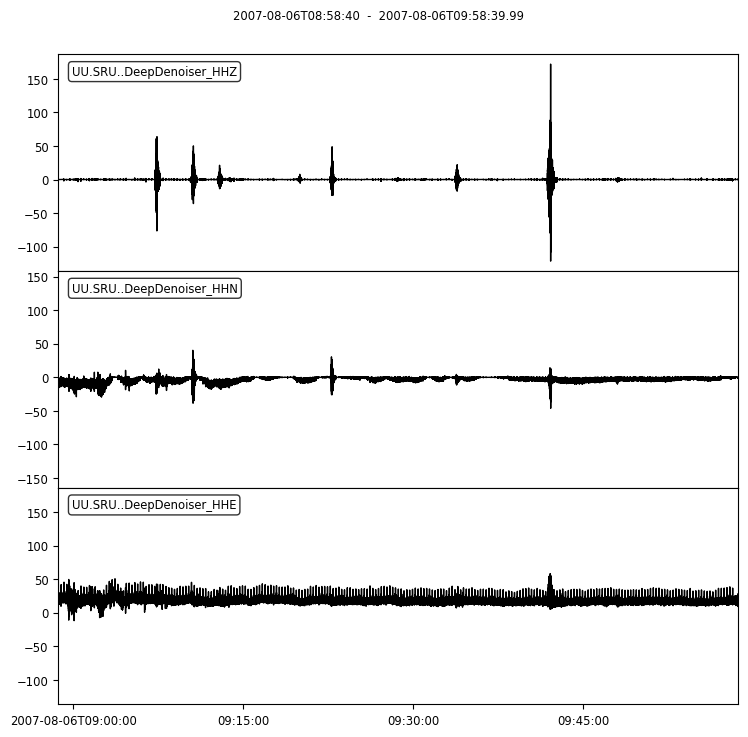

In [205]:
## Excercise
# Try denoising the original stream (cc_stream) and plotting it.
# hint: don't overwrite the variable "denoised_st", we will use it later.

denoised_2 = denoiser.annotate(cc_stream)
denoised_2.plot();

-> **Comparing this output with the previous, what indications are there something might be going wrong?**

The HHE plot of the denoised original stream (cc_stream) does not really have defined spikes and is way too constant to correctly represent this data. It has constant noise, so the denoiser did not work on HHE. The HHN is relatively weird too, as it has noise throughout as well and a lot of noise at the beginning. 

## Phase Picking

Prior to sophisticated deep-learning models, phase picking was largely done manually, or high errors produced by simple models were tolerated. Now, automatic picking can be performed with near-human performance. This is a major time saver and enables the analysis of larger datasets.



 One of the most popular phase pickers is called [PhaseNet](https://academic.oup.com/gji/article/216/1/261/5129142). It is a [U-Net](https://en.wikipedia.org/wiki/U-Net) trained on California earthquakes.

 The Phasenet model's `annotate` method returns a new stream, with each trace representing the estimated probability of noise, P, and S, for each sample, respectively.

In [206]:
# Get a phasenet picker.
pn_model = sbm.PhaseNet.from_pretrained("original")

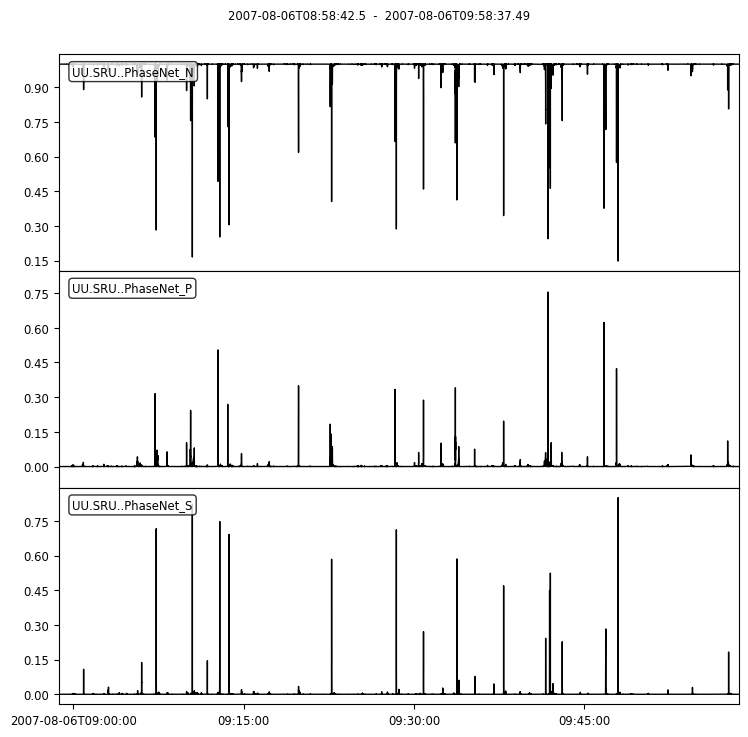

In [207]:
# Get probability estimates of each part of the stream being a P or S arrival.
pn_preds = pn_model.annotate(cc_stream)
pn_preds.plot(show=False)

The `classify` method parses the output and returns a list of picks. Picks are made when the probability of P or S phases exceeds some threshold.

In [208]:
# Make pick estimates.
picks = pn_model.classify(cc_stream).picks

In [209]:
# Convert picks to a table (pandas dataframe).
pick_df = to_df(picks)
pick_df

,trace_id,start_time,end_time,peak_time,peak_value,phase,time,network,station
0,UU.SRU.,2007-08-06 09:07:11.730,2007-08-06 09:07:11.910,2007-08-06 09:07:11.730,0.315590,P,0.00,UU,SRU
1,UU.SRU.,2007-08-06 09:07:17.510,2007-08-06 09:07:17.910,2007-08-06 09:07:17.670,0.716142,S,5.94,UU,SRU
2,UU.SRU.,2007-08-06 09:10:28.480,2007-08-06 09:10:28.840,2007-08-06 09:10:28.630,0.822141,S,196.90,UU,SRU
3,UU.SRU.,2007-08-06 09:12:44.450,2007-08-06 09:12:44.950,2007-08-06 09:12:44.580,0.504374,P,332.85,UU,SRU
4,UU.SRU.,2007-08-06 09:12:53.360,2007-08-06 09:12:53.720,2007-08-06 09:12:53.540,0.747149,S,341.81,UU,SRU
5,UU.SRU.,2007-08-06 09:13:42.690,2007-08-06 09:13:43.100,2007-08-06 09:13:42.830,0.691408,S,391.10,UU,SRU
6,UU.SRU.,2007-08-06 09:19:50.060,2007-08-06 09:19:50.280,2007-08-06 09:19:50.100,0.349300,P,758.37,UU,SRU
7,UU.SRU.,2007-08-06 09:22:44.710,2007-08-06 09:22:45.130,2007-08-06 09:22:44.870,0.583995,S,933.14,UU,SRU
8,UU.SRU.,2007-08-06 09:28:20.180,2007-08-06 09:28:20.330,2007-08-06 09:28:20.210,0.333919,P,1268.48,UU,SRU
9,UU.SRU.,2007-08-06 09:28:27.030,2007-08-06 09:28:27.440,2007-08-06 09:28:27.220,0.711370,S,1275.49,UU,SRU


In [210]:
## Excercise
# Try running the same process on the denoised_st. Print how many picks it
# found.

# Get a phasenet picker.
pn_model = sbm.PhaseNet.from_pretrained("original")

# Get probability estimates of each part of the stream being a P or S arrival.
pn_preds = pn_model.annotate(denoised_st)
pn_preds.plot(show=False)

# Make pick estimates.
picks = pn_model.classify(denoised_st).picks

# Convert picks to a table (pandas dataframe).
pick_df = to_df(picks)
pick_df

,trace_id,start_time,end_time,peak_time,peak_value,phase,time,network,station
0,UU.SRU.,2007-08-06 08:59:50.300,2007-08-06 08:59:50.610,2007-08-06 08:59:50.420,0.410100,P,0.00,UU,SRU
1,UU.SRU.,2007-08-06 08:59:55.680,2007-08-06 08:59:56.000,2007-08-06 08:59:55.830,0.667980,P,5.41,UU,SRU
2,UU.SRU.,2007-08-06 08:59:59.330,2007-08-06 08:59:59.640,2007-08-06 08:59:59.470,0.441914,S,9.05,UU,SRU
3,UU.SRU.,2007-08-06 09:00:51.890,2007-08-06 09:00:52.240,2007-08-06 09:00:52.030,0.524057,P,61.61,UU,SRU
4,UU.SRU.,2007-08-06 09:00:53.570,2007-08-06 09:00:53.950,2007-08-06 09:00:53.730,0.824688,S,63.31,UU,SRU
...,...,...,...,...,...,...,...,...,...
87,UU.SRU.,2007-08-06 09:56:25.920,2007-08-06 09:56:26.360,2007-08-06 09:56:26.180,0.455437,S,3395.76,UU,SRU
88,UU.SRU.,2007-08-06 09:57:13.860,2007-08-06 09:57:14.230,2007-08-06 09:57:14.040,0.742979,S,3443.62,UU,SRU
89,UU.SRU.,2007-08-06 09:57:35.760,2007-08-06 09:57:36.060,2007-08-06 09:57:35.850,0.444963,P,3465.43,UU,SRU
90,UU.SRU.,2007-08-06 09:57:38.640,2007-08-06 09:57:38.840,2007-08-06 09:57:38.700,0.341143,S,3468.28,UU,SRU


-> **Did performing the phase picking on the denoised work better? How do you know?**

It returned more than 4x the picks, but we aren't sure if these are all real.

If these are real, then the phase picking on the denoised data works better. As more picks should lead to a better understanding of the data.

SeisBench has several phasenet weights (run `sbm.PhaseNet.list_pretrained()` to see them) and other models for phase picking such as `GPD` and `EQTransformer` which each have several options for weights.

['diting', 'ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'obs', 'original', 'scedc', 'stead']


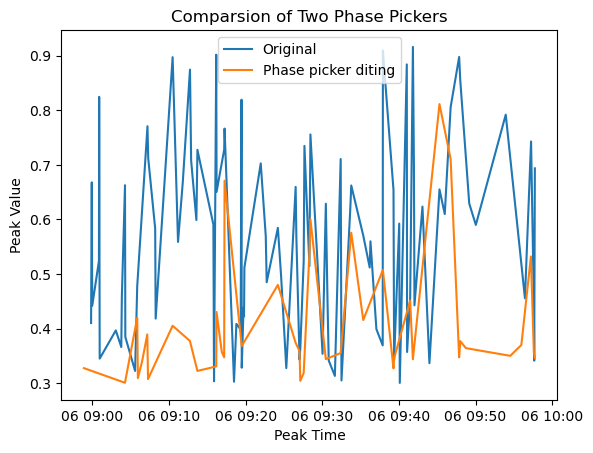

In [211]:
## Excercise
# Select another phase picker or phasenet weight and run it again on the
# denoised data. Plot the original phase net picks and the new ones.
# The peak_time should be the x axis and peak_value on the y axis.
# Hint: Use a dot, x, or other symbol. The line plot looks messy.

print(sbm.PhaseNet.list_pretrained())

# Get a phasenet picker.
pn_model_2 = sbm.PhaseNet.from_pretrained("diting")

# Get probability estimates of each part of the stream being a P or S arrival.
pn_preds_2 = pn_model_2.annotate(denoised_st)
pn_preds_2.plot(show=False)

# Make pick estimates.
picks_2 = pn_model_2.classify(denoised_st).picks

# Convert picks to a table (pandas dataframe).
pick_df_2 = to_df(picks_2)
#print(pick_df_2)

plt.plot(pick_df['peak_time'], pick_df['peak_value'], label='Original')
plt.plot(pick_df_2['peak_time'], pick_df_2['peak_value'], label='Phase picker diting')
plt.xlabel('Peak Time')
plt.ylabel('Peak Value')
plt.title('Comparsion of Two Phase Pickers')
plt.legend()

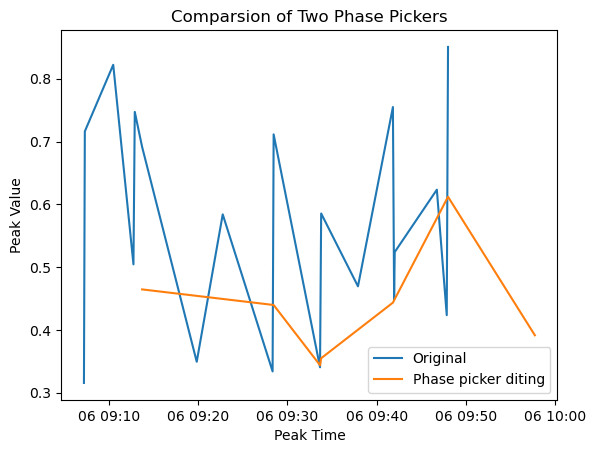

In [212]:
## Excercise
# Using the same two pickers as before, get phase picks from the original
# (not denoised) data and plot.
# Hint: This should be nearly identical as the previous excercise, just
# change one variable name.

#Original
# Get a phasenet picker for original
pn_model = sbm.PhaseNet.from_pretrained("original")

# Get probability estimates of each part of the stream being a P or S arrival.
pn_preds = pn_model.annotate(cc_stream)
pn_preds.plot(show=False)

# Make pick estimates.
picks = pn_model.classify(cc_stream).picks

# Convert picks to a table (pandas dataframe).
pick_df = to_df(picks)
#print(pick_df)


#Obs Phase Picker
# Get a phasenet picker.
pn_model_2 = sbm.PhaseNet.from_pretrained("diting")

# Get probability estimates of each part of the stream being a P or S arrival.
pn_preds_2 = pn_model_2.annotate(cc_stream) #original data
pn_preds_2.plot(show=False)

# Make pick estimates.
picks_2 = pn_model_2.classify(cc_stream).picks

# Convert picks to a table (pandas dataframe).
pick_df_2 = to_df(picks_2)
#print(pick_df_2)

plt.plot(pick_df['peak_time'], pick_df['peak_value'], label='Original')
plt.plot(pick_df_2['peak_time'], pick_df_2['peak_value'], label='Phase picker diting')
plt.xlabel('Peak Time')
plt.ylabel('Peak Value')
plt.title('Comparsion of Two Phase Pickers')
plt.legend()

-> **Looking at both outputs, which do you trust more and why?**

I trust the denoised data more, because there is more of a coorelation between the two graphs. While with the original data (second one), the diting data has a low coorleation if any at all with the original phase picker. The denosied data also has more observed data, which means it may be more efficient if the data is correct.

# Part 3: Aftershock Processing

For the final section, we will detect and locate aftershocks from the [2020 Salt Lake City Earthquake](https://en.wikipedia.org/wiki/2020_Salt_Lake_City_earthquake#:~:text=At%207%3A09%20AM%20MDT,the%20planned%20Utah%20Inland%20Port.). This is the event we studied with our analog processing activity in class.

The following table shows basic information about the event:

|                |                     |
|----------------|---------------------|
| UTC time       | 2020-03-18T13:09:31 |
| Magnitude (Mw) | 5.7                 |
| Depth          | 11.7km              |
| Latitude       | 40.851 N            |
| Longitude      | 112.081 W           |


In [213]:
#@title Section 3 Utilities
# Utility code for this section. Simply run this cell and move on.
from collections import Counter
from pathlib import Path

import pyocto


def load_seismic_data(path, only_3c=True):
    """
    Load the waveform and station data in a directory.

    The directory must have subfolders name "waveforms" and "stations".

    Parameters
    ----------
    path
        The directory path which contains the data.
    only_3c
        If True, only load data that has 3 components.
    """

    path = Path(path)
    # Ensure expected paths exist.
    wave_folder_path = path / "waveforms"
    sta_folder_path = path / "stations"
    assert wave_folder_path.is_dir(), f"{wave_folder_path} does not exist"
    assert sta_folder_path.is_dir(), f"{sta_folder_path} does not exist"
    # Load waveforms into stream.
    st = obspy.Stream()
    for wpath in wave_folder_path.glob("*.mseed"):
        st += obspy.read(wpath)
    # Filter stream to only include stations with 3 components.
    if only_3c:
        count = Counter([tr.stats.station for tr in st])
        has_3c = {i for i, v in count.items() if v >= 3}
        st = obspy.Stream([tr for tr in st if tr.stats.station in has_3c])
    # Load station info into inventory.
    inv = obspy.Inventory()
    stations = {tr.stats.station for tr in st}
    for sta_path in sta_folder_path.glob("*.xml"):
        sub_inv = obspy.read_inventory(sta_path)
        # Only include stations that are in stream.
        if sub_inv[0][0].code in stations:
            inv += sub_inv
    return st, inv



def inventory_to_df(inv):
    """
    Extract station names and locations to a dataframe.

    Parameters
    ----------
    inv
        The obspy Inventory object.
    """
    data = []
    for network in inv.networks:
        for station in network.stations:
            sta_info = {
                "network": network.code,
                "station": station.code,
                "latitude": station.latitude,
                "longitude": station.longitude,
                "elevation": station.elevation,
                "id": network.code + '.' + station.code + ".'",
            }
            data.append(sta_info)
    return pd.DataFrame(data)


## Download data
ObsPy's [Mass Data Downloader](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html) provides a convinient way to, well, download lots of seismic data. We will use it to get waveforms and station info about the event.

NOTE: All the data are saved in a directory called "data" which you can find in the file explorer.

In [214]:
#@title Download aftershock data
#%%capture
from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader

origin_time = obspy.UTCDateTime(2020, 3, 18, 13, 9, 31)

time_1 = origin_time + 900
time_2 = time_1 + 60 * 60

latitude = 40.851
longitude = -112.081

# Circular domain around the epicenter. This will download all data between
# 0.5 and 3 degrees distance from the epicenter.
domain = CircularDomain(latitude=latitude, longitude=longitude,
                        minradius=0.0, maxradius=2.5)

restrictions = Restrictions(
    # Get data 10 second before the event to 2 minutes after.
    starttime=time_1,
    endtime=time_2,
    # Reject gappy/missing data
    reject_channels_with_gaps=True,
    minimum_length=1.0,
    # No two stations should be closer than 10 km to each other.
    minimum_interstation_distance_in_m=10E3,
    # Just get stations from UUSS.
    network='UU',
    # Only broadband (HH or BH) channels.
    channel_priorities=["HH[ZNE]", "BH[ZNE]"],
    # location_priorities=["", "00", "10"])
)

mdl = MassDownloader(["IRIS"])
# The data will be downloaded to the ``mainshock/waveforms/`` and ``mainshock/stations/``
# folders with automatically chosen file names.
mdl.download(domain, restrictions, mseed_storage="data/waveforms",
             stationxml_storage="data/stations")

[2024-04-02 19:50:52,571] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-04-02 19:50:52,571] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-04-02 19:50:52,571] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-04-02 19:50:52,571] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-04-02 19:50:52,571] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-04-02 19:50:52,571] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-04-02 19:50:52,571] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-04-02 19:50:52,584] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2024-04-02 19:50:52,584] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2024-0

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x1532bfc90>}

## PyOcto demo

[PyOcto](https://github.com/yetinam/pyocto) is an efficient pick associator. Essentially, it takes a basic velocity model and station locations into account to find locations and picks which are consistent with seismic events.

The following code demonstrates how to use PyOcto with SeisBench.

In [215]:
# Load the streams and inventory.
st, inv = load_seismic_data("data")

In [216]:
# Use the original phase net model to make picks.
pn_model = sbm.PhaseNet.from_pretrained("original")
picks = pn_model.classify(st).picks

In [217]:
# Create the PyOcto associator.
velocity_model = pyocto.VelocityModel0D(
    p_velocity=6,
    s_velocity=3.0,
    tolerance=2.0,
)

associator = pyocto.OctoAssociator.from_area(
    lat=(39, 43),
    lon=(-114, -110),
    zlim=(0, 100),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=9,
    n_p_picks=3,
    n_s_picks=2,
    n_p_and_s_picks=1,
)

Prepare input data for the associator.

In [218]:
# PyOcto provides a way to convert an inventory to a Pandas dataframe.
stations = associator.inventory_to_df(inv)

In [219]:
# Then we simply feed the associator the picks and stations to it.
events, assignments = associator.associate_seisbench(picks, stations)

In [220]:
# And use transform to add lat/lon back to events df.
associator.transform_events(events)

# Convert timestamps to datetimes.
events['time'] = pd.to_datetime(events['time'], unit='s')

In [221]:
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2020-03-18 13:26:20.317232384,-2.030393,-28.182493,0.390625,12,40.746219,-112.024041,0.390625
1,1,2020-03-18 13:27:21.088569600,-2.030393,-29.925296,0.390625,14,40.730525,-112.024035,0.390625
2,2,2020-03-18 13:29:55.009270016,-4.737584,-27.311091,9.765625,22,40.754055,-112.056101,9.765625
3,3,2020-03-18 13:30:52.303591680,-3.383988,-36.025106,13.671875,9,40.675591,-112.040025,13.671875
4,4,2020-03-18 13:31:18.752703232,-0.676798,-27.311091,0.390625,17,40.754068,-112.008014,0.390625
5,5,2020-03-18 13:32:28.729744640,-7.444774,-28.182493,12.890625,23,40.746188,-112.088149,12.890625
6,6,2020-03-18 13:33:35.239116800,-2.030393,-15.111472,25.390625,10,40.863923,-112.024083,25.390625
7,7,2020-03-18 13:35:15.102667008,-3.383988,-24.696887,0.390625,9,40.777602,-112.040086,0.390625
8,8,2020-03-18 13:36:36.629903360,-12.859156,-29.053894,16.015625,20,40.738274,-112.152239,16.015625
9,9,2020-03-18 13:39:51.053533952,-3.383988,-27.311091,0.390625,10,40.754061,-112.040072,0.390625


In [222]:
## Exercise
# Above we found 5 aftershocks. Using the techniques you learned in previous
# sections,be creative, and see if you can do better. You can also play around
# with the input parameters to the associator. Then make a map plot of the
# aftershocks you found by coloring the dots according to number of picks.
# Also show the original event as a star and the stations as triangles.


-> **Comment on the apparent clustering of the aftershocks and over quality. Is there anything to indicate some may be noise?**
